In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')

In [2]:
df = ML_data[['METHOD_MIC','MUT_RESISTANCE','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth']]

# creates features numpy array
features = df[df.columns[2:]].to_numpy()

#creates resistance label column
label = df['MUT_RESISTANCE'].to_numpy()

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

#create logistic regression pipeline with preprocessing 
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression(max_iter=10000))])
#create parameter grid with different preprocessing and classifier parameters
param_grid = {'preprocessing':[StandardScaler(), MinMaxScaler(), RobustScaler(), None],
              'classifier__C': [0.01, 0.1, 1, 10, 100]}

#split data into training and test sets
X_train1, X_test, y_train1, y_test = train_test_split(features, label,
                                                    random_state=0)

In [4]:
# creates features and label dfs from unique mutations in the training split

#converts long X_train and y_train to pd df to join
X_train_df = pd.DataFrame(X_train1)
y_train_df = pd.DataFrame(y_train1)
y_train_df.rename(columns = {0:'MUT_RESISTANCE'}, inplace = True)
CV_train = X_train_df.join(y_train_df,  how = 'inner')

#adds mutation column to df so rows can be identified by mutation
mutation_index_s = ML_data['MUTATION']
mutation_index_pd = pd.Series(mutation_index_s)
mutation_index = mutation_index_pd.to_frame()
CV_training_and_mutations = CV_train.join(mutation_index, how = 'inner')

#removes duplicates and mutation column
CV_train_unique = CV_training_and_mutations.drop_duplicates(subset='MUTATION', keep = 'first')
CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

#seperates into unique features and label numpy arrays
features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
label_unique = CV_train_unique['MUT_RESISTANCE']

X_train = (features_unique)
y_train = (label_unique)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
#Grid search with stratified cross validation
grid_strat = GridSearchCV(pipe, param_grid, cv=5)
grid_strat.fit(X_train, y_train)
print ('grid_strat: best estimator: \n', grid_strat.best_estimator_)
print ('grid_strat: best cross-validation score :', grid_strat.best_score_, '\n')
print ('grid_strat: test set average accuracy :', 
       accuracy_score(y_test, grid_strat.predict(X_test)))

grid_strat: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=0.01, max_iter=10000))])
grid_strat: best cross-validation score : 0.9715284715284715 

grid_strat: test set average accuracy : 0.9657193085262232


In [6]:
#Grid search with kfold cross validation
Kfold = KFold(n_splits=5)
grid_kfold = GridSearchCV(pipe, param_grid, cv=Kfold)
grid_kfold.fit(X_train, y_train)
print ('grid_kfold: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold: best cross-validation score :', grid_kfold.best_score_, '\n')
print ('grid_kfold: test set average accuracy :', 
       accuracy_score(y_test, grid_kfold.predict(X_test)))

grid_kfold: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=0.01, max_iter=10000))])
grid_kfold: best cross-validation score : 0.9688977688977689 

grid_kfold: test set average accuracy : 0.9657193085262232


In [7]:
#Search with shuffled cross validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=Kfold_shuffle)
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test, grid_kfold_shuffle.predict(X_test)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=0.1, max_iter=10000))])
grid_kfold_shuffle: best cross-validation score:  0.968997668997669
grid_kfold_shuffle: test set average accuracy:  0.9645473190741284 



In [8]:
#Grid search with with stratified cross validation
#use decision function to calculate average_precision
grid_strat = GridSearchCV(pipe, param_grid, cv=5, scoring='average_precision')
grid_strat.fit(X_train, y_train)
print ('grid_strat: best estimator: \n', grid_strat.best_estimator_)
print ('grid_strat: best cross-validation score: ', grid_strat.best_score_)                  
print ('grid_strat: test set average precision: ', 
       average_precision_score(y_test, grid_strat.decision_function(X_test)), '\n')

grid_strat: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=0.01, max_iter=10000))])
grid_strat: best cross-validation score:  0.9994473622639275
grid_strat: test set average precision:  0.999021575251239 



In [9]:
#Grid search with with kfold cross validation
#use decision function to calculate average_precision
kfold = KFold(n_splits=5)
grid_kfold = GridSearchCV(pipe, param_grid, cv=kfold, scoring='average_precision')
grid_kfold.fit(X_train, y_train)
print ('grid_kfold: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold: best cross-validation score: ', grid_kfold.best_score_)                  
print ('grid_kfold test set average precision: ', 
       average_precision_score(y_test, grid_kfold.decision_function(X_test)), '\n')

grid_kfold: best estimator: 
 Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])
grid_kfold: best cross-validation score:  0.999394311176274
grid_kfold test set average precision:  0.9992606958597934 



In [10]:
#Grid search with with shuffled cross validation
#use decision function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test, grid_kfold_shuffle.decision_function(X_test)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier', LogisticRegression(C=100, max_iter=10000))])
grid_kfold_shuffle: best cross-validation score:  0.9995574930861384
grid_kfold_shuffle test set average precision:  0.9992941613952065 



In [11]:
#Grid search with with stratified cross validation
#use decision function to calculate AUC

grid_strat = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
grid_strat.fit(X_train, y_train)
print ('grid_strat: best estimator: \n', grid_strat.best_estimator_)
print ('grid_strat: best cross-validation score: ', grid_strat.best_score_)                  
print ('grid_strat: test set AUC: ', 
       roc_auc_score(y_test, grid_strat.decision_function(X_test)), '\n')

grid_strat: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=100, max_iter=10000))])
grid_strat: best cross-validation score:  0.9909056316590563
grid_strat: test set AUC:  0.9828628781921277 



In [12]:
#Grid search with with kfold cross validation
#use decision function to calculate AUC
kfold = KFold(n_splits=5)
grid_kfold = GridSearchCV(pipe, param_grid, cv=kfold, scoring='roc_auc')
grid_kfold.fit(X_train, y_train)
print ('grid_kfold: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold: best cross-validation score: ', grid_kfold.best_score_)                  
print ('grid_kfold test set AUC: ', 
       roc_auc_score(y_test, grid_kfold.decision_function(X_test)), '\n')

grid_kfold: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LogisticRegression(C=0.1, max_iter=10000))])
grid_kfold: best cross-validation score:  0.9907812371303846
grid_kfold test set AUC:  0.9845142999048053 



In [13]:
#Grid search with with shuffled kfold cross validation
#use decision function to calculate AUC
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train, y_train)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test, grid_kfold_shuffle.decision_function(X_test)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])
grid_kfold_shuffle: best cross-validation score:  0.9922624664023468
grid_kfold_shuffle test set AUC:  0.9835561441993295 



[0.95860247 0.95859031 0.95887192 0.95915369 0.96       0.96056504
 0.96141384 0.96169711 0.96198055 0.96226415 0.96224189 0.96223075
 0.96308328 0.96306147 0.96305055 0.9633353  0.96362023 0.96390533
 0.96419059 0.96447602 0.9644655  0.96475118 0.96474074 0.96502667
 0.96500593 0.96499555 0.9652819  0.96556842 0.96585511 0.9667162
 0.96700357 0.96757882 0.96756918 0.96755952 0.96784757 0.967838
 0.96841478 0.96840537 0.9686941  0.96868476 0.96897375 0.96926291
 0.96925373 0.96924455 0.96953405 0.96952495 0.9698147  0.96980568
 0.96979665 0.97008675 0.97006884 0.97035928 0.9706499  0.9706411
 0.97060588 0.97089709 0.97118848 0.97117983 0.97147147 0.97557298
 0.97556561 0.97555824 0.9758527  0.97578692 0.97577226 0.97636364
 0.97665959 0.97695573 0.97694874 0.97694175 0.97693475 0.97692775
 0.97722442 0.97720365 0.97750076 0.97779805 0.97869102 0.97867804
 0.97897623 0.97896983 0.97926829 0.97956694 0.97956071 0.97985963
 0.98015873 0.98014661 0.98014054 0.9804401  0.98043412 0.98042215

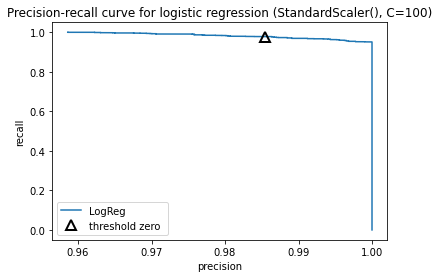

In [22]:
#use best preprocessing (standard scaler) and parameters (c=100) for av. precision
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
import numpy as np

pipe = Pipeline([('preprocessing', StandardScaler()), 
                ('classifier', LogisticRegression(C=100, max_iter=10000))])
    
pipe.fit(X_train, y_train)
predict = (pipe.decision_function(X_test))

precision, recall, thresholds = precision_recall_curve(y_test, predict)

plt.plot(precision, recall, label='LogReg')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], '^', c='k', 
              markersize=10, label='threshold zero ', fillstyle='none', mew=2)
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc='best')
plt.title('Precision-recall curve for logistic regression (StandardScaler(), C=100)')
    
print(precision)

Text(0.5, 1.0, 'ROC curve for logistic regression (StandardScaler(), C=100)')

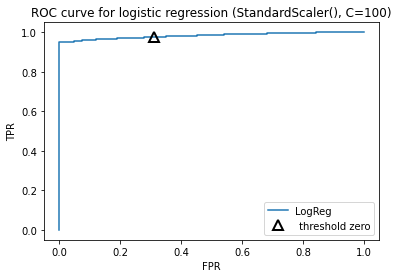

In [23]:
#use best preprocessing (standard scaler) and parameters (c=100) for av. precision
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pipe.decision_function(X_test))

plt.plot(fpr, tpr, label='LogReg')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], '^', c='k',
         markersize=10, label=' threshold zero', fillstyle='none', mew=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')
plt.title('ROC curve for logistic regression (StandardScaler(), C=100)')

In [28]:
#confusion matrix (StandardScaler, C=100)

from sklearn.metrics import confusion_matrix

#build and fit pipieline
pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', LogisticRegression(C=100, max_iter=10000))])

pipe.fit(X_train, y_train)
predict = pipe.predict(X_test).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test, predict)

#calculate precision, sensitivity, specifcity, FPR, erros
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
#very_major_error = (confusion[0][1]/y_test[y_test==0].count())*100
#major_error = (confusion[1][0]/y_test[y_test==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
#print ('very major error :', very_major_error)
#print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.9854983029929034
Sensitivity:  0.9782542113323124
Specificity:  0.6824324324324325
FPR : 0.31756756756756754

 confusion matrix: 
 [[ 101   47]
 [  71 3194]]
